# Imports

In [1]:
from pyathena import connect
import pandas as pd
import numpy as np
import seaborn as sns

from pathlib import Path 
current_path = Path().resolve()

RAW_PATH = current_path.parent / 'data' / 'raw'
OUTPUT_PATH = current_path.parent / 'data' / 'output'

pd.set_option('display.max_columns', 500)

%matplotlib inline

# Connections

In [2]:
conn = connect(s3_staging_dir='s3://athena-robusta/teste',
               region_name='us-east-2')

# OSM Data

https://taginfo.openstreetmap.org/keys

In [13]:
sample = pd.read_sql_query('SELECT * FROM "pollution"."osm_hexagons_flatten" limit 10;', conn)

In [14]:
sample.head(4)

,h3id_9,no_med,no2_med,bc_med,city,polygon,__index_level_0__,id,type,tags,lat,lon,nds,members,changeset,timestamp,uid,user,version
0,89283081003ffff,7.52,16.735806,0.482257,1,POLYGON((37.80546170106164 -122.27136954298386...,0,1409407230,node,"{website=http://www.citycarshare.org/, ref=12,...",37.806081,-122.273047,[],[],28120512,2015-01-13 20:09:47,355242,Bryce C Nesbitt,3
1,89283081003ffff,7.52,16.735806,0.482257,1,POLYGON((37.80546170106164 -122.27136954298386...,0,3999477032,node,"{parking=garage, amenity=parking}",37.806821,-122.273568,[],[],37129638,2016-02-10 17:12:45,381909,JessAk71,1
2,89283081003ffff,7.52,16.735806,0.482257,1,POLYGON((37.80546170106164 -122.27136954298386...,0,3999477031,node,"{shop=books, name=Cape & Cowl Comics}",37.806774,-122.272849,[],[],37129638,2016-02-10 17:12:45,381909,JessAk71,1
3,89283081003ffff,7.52,16.735806,0.482257,1,POLYGON((37.80546170106164 -122.27136954298386...,0,3999477030,node,"{shop=dry_cleaner, name=A Stitch'N Time}",37.806895,-122.272772,[],[],37129638,2016-02-10 17:12:45,381909,JessAk71,1


In [15]:
update_log = pd.read_sql_query("""SELECT CAST(timestamp as date) as date,
count(*) as counta
FROM "pollution"."osm_hexagons_flatten"
GROUP BY CAST(timestamp as date)""", conn)

In [16]:
update_log.head(1)

,date,counta
0,2018-03-02,1403


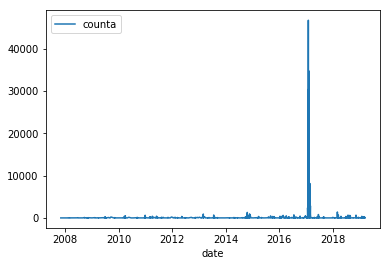

In [17]:
update_log.sort_values(by='date').plot(x='date')

# Pollution data

In [7]:
pollution = pd.read_sql_query('SELECT * FROM "pollution"."pollution"', conn)

In [8]:
pollution.head()

,h3id_9,no_med,no2_med,bc_med,city,polygon,__index_level_0__
0,89283081003ffff,7.520000,16.735806,0.482257,1,POLYGON((37.80546170106164 -122.27136954298386...,0
1,89283081007ffff,13.872691,18.181686,0.671507,1,POLYGON((37.806792511198935 -122.2749626236637...,1
2,8928308100bffff,11.260767,17.966785,0.603836,1,POLYGON((37.80731898808136 -122.26796037726164...,2
3,8928308100fffff,8.714581,17.404857,0.493472,1,POLYGON((37.80864987554612 -122.27155355691563...,3
4,89283081013ffff,11.153846,17.959754,0.534913,1,POLYGON((37.802273442858386 -122.2711855401243...,4


In [10]:
pollution.to_csv(RAW_PATH / 'pollution-h3.csv')

In [13]:
pollution['h3id_9'].to_csv(RAW_PATH / 'h3_address.csv')

In [14]:
pollution['polygon'].rename(columns={'polygon': 'wkt'}).to_csv(RAW_PATH / 'h3.csv')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1137609e8>]],
      dtype=object)

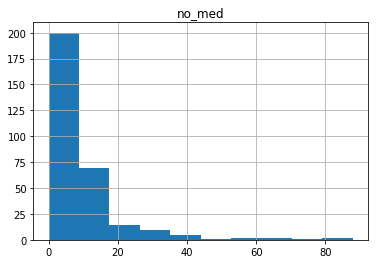

In [5]:
pollution[['no_med']].hist()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1138ca198>]],
      dtype=object)

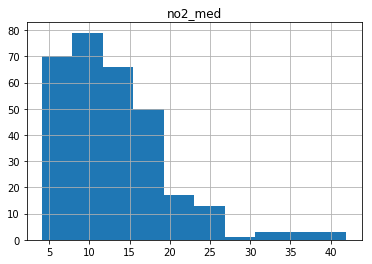

In [6]:
pollution[['no2_med']].hist()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x113848908>]],
      dtype=object)

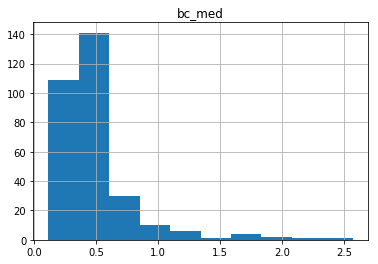

In [7]:
pollution[['bc_med']].hist()

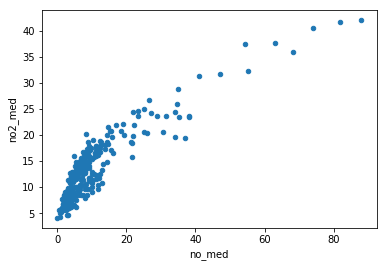

In [8]:
pollution.plot(x='no_med', y='no2_med', kind='scatter')

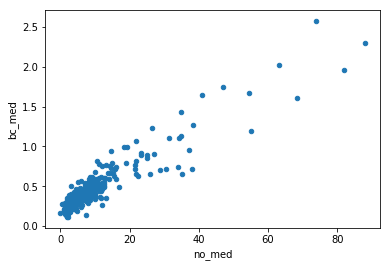

In [9]:
pollution.plot(x='no_med', y='bc_med', kind='scatter')

# Features

The intent of OSM features is to get surrounding characteristics:

0. Overall
1. Urban x Rural
2. Residential x Comercial x Industrial
3. Places of Interest (POIs)
4. Recreational activity 

In [10]:
query = """
SELECT 
  t1.h3id_9,
  MAX(no_med) as no_med,
  MAX(no2_med) as no2_med,
  MAX(bc_med) as bc_med,
  MAX(city) as city,
  -- general features
  COUNT(*) as general_counta,
  COUNT (DISTINCT osm_id) as node_counta,
  COUNT (DISTINCT info) as info_counta,
  -- road type
  SUM(CASE WHEN info = 'highway' THEN 1 ELSE 0 END) as highway_counta,

  -- urban x rural
  SUM(CASE WHEN info = 'natural' THEN 1 ELSE 0 END) as natural_counta,
  SUM(CASE WHEN info = 'place' THEN 1 ELSE 0 END) as place_counta, -- place tags are mostly for small localities
  SUM(CASE WHEN info = 'parking' THEN 1 ELSE 0 END) as parking_counta,   
  SUM(CASE WHEN info = 'addr:street' THEN 1 ELSE 0 END) as addr_street_counta,   
  SUM(CASE WHEN info = 'addr:housenumber' THEN 1 ELSE 0 END) as addr_housenumber_counta, 
  -- places of interest
  SUM(CASE WHEN info = 'amenity' THEN 1 ELSE 0 END) as amenity_counta,
  SUM(CASE WHEN info = 'school' THEN 1 ELSE 0 END) as school_counta,
  SUM(CASE WHEN info = 'restaurant' THEN 1 ELSE 0 END) as restaurant_counta,
  SUM(CASE WHEN info = 'place_of_worship' THEN 1 ELSE 0 END) as place_of_worship_counta,
  SUM(CASE WHEN info = 'shop' THEN 1 ELSE 0 END) as shop_counta,
    SUM(CASE WHEN info = 'name' THEN 1 ELSE 0 END) as name,
    SUM(CASE WHEN info = 'parking' THEN 1 ELSE 0 END) as parking,
    SUM(CASE WHEN info = 'crossing' THEN 1 ELSE 0 END) as crossing
FROM pollution.osm_hexagons_open t1
JOIN pollution.pollution t2
ON t1.h3id_9 = t2.h3id_9
GROUP BY t1.h3id_9
"""

In [11]:
features = pd.read_sql_query(query, con=conn)

In [12]:
features.to_csv(RAW_PATH / 'pollution-features.csv', index=False)

In [13]:
features = pd.read_csv(RAW_PATH / 'pollution-features.csv')

In [14]:
features.head()

,h3id_9,no_med,no2_med,bc_med,city,general_counta,node_counta,info_counta,highway_counta,natural_counta,place_counta,parking_counta,addr_street_counta,addr_housenumber_counta,amenity_counta,school_counta,restaurant_counta,place_of_worship_counta,shop_counta,name,parking,crossing
0,892830813b7ffff,8.296297,16.261263,0.554605,1,6,2,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,89283098197ffff,4.794746,6.616649,0.185375,2,6,2,5,2,0,0,0,0,0,0,0,0,0,0,0,0,0
2,89283099cb7ffff,2.466667,7.034080,0.258562,2,100,6,35,5,0,0,0,0,0,0,0,0,0,0,5,0,0
3,89283081197ffff,46.999998,31.751069,1.746473,1,22,11,6,2,0,0,0,0,0,0,0,0,0,0,0,0,0
4,89283081547ffff,10.504504,19.025962,0.815375,1,36,18,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [15]:
features.groupby('city').count()['no_med']

city
1    137
2    154
Name: no_med, dtype: int64

In [16]:
features.head(1)

,h3id_9,no_med,no2_med,bc_med,city,general_counta,node_counta,info_counta,highway_counta,natural_counta,place_counta,parking_counta,addr_street_counta,addr_housenumber_counta,amenity_counta,school_counta,restaurant_counta,place_of_worship_counta,shop_counta,name,parking,crossing
0,892830813b7ffff,8.296297,16.261263,0.554605,1,6,2,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [17]:
features.describe()

,no_med,no2_med,bc_med,city,general_counta,node_counta,info_counta,highway_counta,natural_counta,place_counta,parking_counta,addr_street_counta,addr_housenumber_counta,amenity_counta,school_counta,restaurant_counta,place_of_worship_counta,shop_counta,name,parking,crossing
count,291.000000,291.000000,291.000000,291.000000,291.000000,291.000000,291.000000,291.000000,291.000000,291.000000,291.000000,291.000000,291.000000,291.000000,291.000000,291.000000,291.000000,291.000000,291.000000,291.000000,291.000000
mean,9.951743,13.158958,0.486367,1.529210,140.542955,22.752577,47.230241,12.378007,0.164948,0.085911,0.147766,0.907216,1.006873,3.168385,0.092784,0.831615,0.202749,1.285223,7.030928,0.147766,13.116838
std,11.405192,6.389179,0.309871,0.500006,175.909442,28.798119,52.209907,14.705197,1.606112,0.292741,0.903339,2.550520,2.876772,9.359625,0.344888,3.026748,0.547842,5.126445,14.946885,0.903339,20.267523
min,0.000000,4.114500,0.113001,1.000000,2.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.737221,8.354940,0.322581,1.000000,41.000000,7.000000,17.500000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
50%,6.937185,12.060148,0.408413,2.000000,90.000000,13.000000,37.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,0.000000,2.000000
75%,10.856543,16.241091,0.534784,2.000000,176.000000,27.000000,54.500000,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,1.000000,7.000000,0.000000,18.000000
max,81.900320,41.613323,2.570939,2.000000,1258.000000,221.000000,366.000000,69.000000,24.000000,2.000000,13.000000,19.000000,19.000000,70.000000,3.000000,22.000000,4.000000,63.000000,142.000000,13.000000,96.000000


# Prepare Database

In [18]:
def prepare_features(features, target):
    try:
        features = features.set_index('h3id_9')
    except:
        pass
    
    columns = [f for f in features.columns if f not in ['no_med', 'no2_med', 'bc_med', 'city', target]]
    df_features = features[columns]
    df_features_colums = df_features.columns
    df_features_index = df_features.index
    from sklearn.preprocessing import MinMaxScaler
    scaler = MinMaxScaler(feature_range=(0, 1))
    df_features = scaler.fit_transform(df_features)
    df_features = pd.DataFrame(df_features, columns=df_features_colums, index=df_features_index)
    X = df_features
    y = features[target]
    X = X.fillna(0)
    return df_features, X, y, df_features_index

# Models

In [19]:
models = {}

In [401]:
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

def get_difference_from_y(X_in, y, models, model_name, index, labels, bins=100, plot=True, save=True, show_metrics=True, feature_coefs=True):
    
    try:
        models[model_name]['y_estimated'] = pd.Series(models[model_name]['model'].predict(X), index=index)
    except:
        models[model_name]['y_estimated'] = models[model_name]['model'].predict(X)
    
    models[model_name]['diff'] = pd.DataFrame(y.values - models[model_name]['y_estimated'],
                                              index=index, columns=['y - y_estimated'])

    
    if plot:
        models[model_name]['diff'][['y - y_estimated']].hist(bins='fd', color='r', alpha=0.5)
        
        fig, ax = plt.subplots()
        pd.DataFrame(y).hist(color='r', alpha=0.5, bins=bins, label='true', ax=ax)
        pd.DataFrame(models[model_name]['y_estimated']).hist(color='b', alpha=0.5, bins=bins, ax=ax, label='estimated')
        ax.set_title('True vs. Estimated')
        plt.show()
        
        
        g = sns.jointplot(pd.Series(y.values, name='y'), 
                      pd.Series(models[model_name]['y_estimated'], name='y_estimated'))
        x0, x1 = g.ax_joint.get_xlim()
        y0, y1 = g.ax_joint.get_ylim()
        lims = [max(x0, y0), min(x1, y1)]
        g.ax_joint.plot(lims, lims, ':k')
        plt.show()
        
    if show_metrics:
        
        mse = mean_squared_error(models[model_name]['y_estimated'], y)
        print('Mean Squared Error: {}'.format(np.sqrt(mse)))
        
    if feature_coefs:
        try:
            print(pd.DataFrame(list(zip( labels, models[model_name]['model'].coef_)), columns=['feature', 'coef']))
        except:
            pass
    
    if save:
        diff.reset_index().to_csv(OUTPUT_PATH / 'pollution_models' / (model_name + '.csv'))

    return models

## Simple Linear Regression with OSM features

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


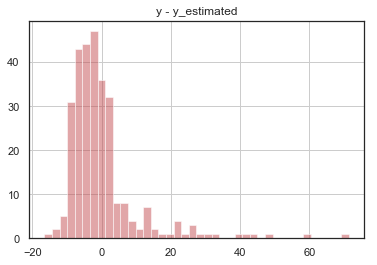

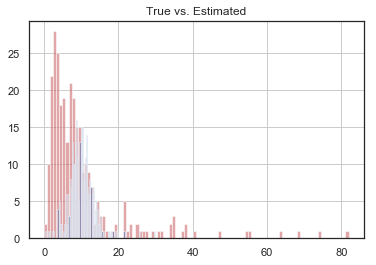

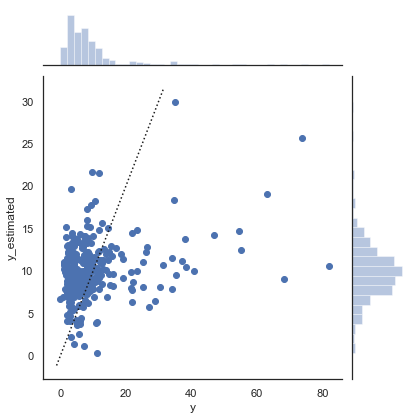

Mean Squared Error: 10.82458341269595
                    feature        coef
0            general_counta  -63.328855
1               node_counta  132.216885
2               info_counta    3.057083
3            highway_counta  -14.780456
4            natural_counta  -18.591961
5              place_counta    0.503939
6            parking_counta   -4.658743
7        addr_street_counta   20.130173
8   addr_housenumber_counta  -17.599955
9            amenity_counta   -6.378133
10            school_counta   -6.888822
11        restaurant_counta   -2.987981
12  place_of_worship_counta   -1.692988
13              shop_counta   -7.609185
14                     name  -17.601654
15                  parking   -4.658743
16                 crossing  -11.765409


AttributeError: 'dict' object has no attribute 'reset_index'

In [288]:
from sklearn.linear_model import LinearRegression

df_features, X, y, index = prepare_features(features, 'no_med')

models['OSM-SimpleLinearRegression'] = {'model': LinearRegression().fit(X, y)}

models = get_difference_from_y(X, y, models, 'OSM-SimpleLinearRegression', index, df_features.columns, bins=100)

## Gamma Regression with OSM data

In [289]:
import numpy as np
import statsmodels.api as sm

df_features, X, y, index = prepare_features(features, 'no_med')
_X = X
_X.insert(0, 'intercept', 1)
columns = [c for c in  _X.columns if c not in ['residential', 'sevice', 'track','parking']]

model = sm.GLM(y.values, _X[columns].values, family=sm.families.Gamma())
models['OSM-SimpleGamma'] = {'model': model.fit(maxiter=1000)}

models['OSM-SimpleGamma']['model'].summary()

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/genmod/generalized_linear_model.py:302: DomainWarning: The inverse_power link function does not respect the domain of the Gamma family.
  DomainWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/genmod/families/family.py:733: RuntimeWarning: divide by zero encountered in log
  ll_obs -= special.gammaln(weight_scale) + np.log(endog)


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:                  291
Model:                            GLM   Df Residuals:                      274
Model Family:                   Gamma   Df Model:                           16
Link Function:          inverse_power   Scale:                          1.0465
Method:                          IRLS   Log-Likelihood:                    inf
Date:                Mon, 08 Apr 2019   Deviance:                       267.46
Time:                        23:07:02   Pearson chi2:                     287.
No. Iterations:                    10   Covariance Type:             nonrobust
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0988      0.011      8.802      0.000       0.077       0.121
x1             0.7751      0.353      2.197      0.028       0.084       1.467
x2            -0.7302      0.167     -4.379      0.000      -1.057      -0.403
x3            -0.0435      0.209     -0.208      0.835      -0.454       0.367
x4            -0.0528      0.127     -0.416      0.678      -0.302       0.196
x5             0.0844      0.096      0.878      0.380      -0.104       0.273
x6            -0.0002      0.050     -0.005      0.996      -0.099       0.099
x7             0.0858      0.137      0.626      0.531      -0.183       0.354
x8            -0.2188      0.284     -0.771      0.441      -0.775       0.338
x9             0.1522      0.267      0.570      0.569      -0.371       0.675
x10           -0.1141      0.212     -0.539      0.590      -0.529       0.301
x11            0.1580      0.105      1.504      0.133      -0.048       0.364
x12            0.0818      0.170      0.481      0.631      -0.252       0.415
x13            0.0397      0.068      0.584      0.559      -0.094       0.173
x14           -0.0044      0.363     -0.012      0.990      -0.715       0.706
x15           -0.0791      0.608     -0.130      0.896      -1.271       1.113
x16            0.0988      0.115      0.859      0.391      -0.127       0.324
==============================================================================
"""

In [290]:
models = get_difference_from_y(X[columns], y, models, 'OSM-SimpleGamma', index, columns,bins=100)

ValueError: shapes (291,18) and (17,) not aligned: 18 (dim 1) != 17 (dim 0)

# Adding Waze Data

## Building Features

In [5]:
query = """
WITH d AS (
  SELECT *
  FROM (
  SELECT *, CAST(hour as INTEGER) as hour_int
  FROM "pollution"."waze_jams_hexagons")
  WHERE hour_int between 6 and 18)

SELECT t1.*, t2.bool_highway, t2.usual_road_type
FROM (
SELECT
  h3id_9,
  MAX(counta) as max_counta,
  AVG(max_length) / MAX(counta) as avg_congested_prop,
  MAX(max_length) as max_length,
  MAX(mean_speed) as max_avg_speed,
  MIN(mean_speed) as min_avg_speed,
  AVG(mean_speed) as avg_speed,
  MAX(median_level) as max_median_level,
  MIN(median_level) as min_median_level,
  approx_percentile(median_level, 0.5) as median_level
  FROM (
SELECT 
  h3id_9,
  pub_utc_date,
  COUNT(uuid) as counta,
  MAX(length) as max_length,
  AVG(speed) as mean_speed,
  approx_percentile(level, 0.5) as median_level
FROM d
GROUP BY h3id_9, pub_utc_date)
GROUP BY h3id_9
) t1
JOIN (
SELECT 
h3id_9,
-- MAX(no2_med) as no2_med,
-- MAX(no_med) as no_med,
-- MAX(bc_med) as bc_med,
MAX(CASE WHEN roadtype = 3 THEN 1 ELSE 0 END) as bool_highway, -- if there is highway in the hexagon,
approx_percentile(roadtype, 0.5) as usual_road_type
FROM d
GROUP BY h3id_9) t2
ON t1.h3id_9 = t2.h3id_9
"""

In [6]:
waze_features = pd.read_sql_query(query, con=conn)

DatabaseError: Execution failed on sql: 
WITH d AS (
  SELECT *
  FROM (
  SELECT *, CAST(hour as INTEGER) as hour_int
  FROM "pollution"."waze_jams_hexagons")
  WHERE hour_int between 6 and 18)

SELECT t1.*, t2.bool_highway, t2.usual_road_type
FROM (
SELECT
  h3id_9,
  polygon,
  MAX(counta) as max_counta,
  AVG(max_length) / MAX(counta) as avg_congested_prop,
  MAX(max_length) as max_length,
  MAX(mean_speed) as max_avg_speed,
  MIN(mean_speed) as min_avg_speed,
  AVG(mean_speed) as avg_speed,
  MAX(median_level) as max_median_level,
  MIN(median_level) as min_median_level,
  approx_percentile(median_level, 0.5) as median_level
  FROM (
SELECT 
  h3id_9,
  pub_utc_date,
  COUNT(uuid) as counta,
  MAX(length) as max_length,
  AVG(speed) as mean_speed,
  approx_percentile(level, 0.5) as median_level
FROM d
GROUP BY h3id_9, pub_utc_date)
GROUP BY h3id_9
) t1
JOIN (
SELECT 
h3id_9,
-- MAX(no2_med) as no2_med,
-- MAX(no_med) as no_med,
-- MAX(bc_med) as bc_med,
MAX(CASE WHEN roadtype = 3 THEN 1 ELSE 0 END) as bool_highway, -- if there is highway in the hexagon,
approx_percentile(roadtype, 0.5) as usual_road_type
FROM d
GROUP BY h3id_9) t2
ON t1.h3id_9 = t2.h3id_9

SYNTAX_ERROR: line 12:3: Column 'polygon' cannot be resolved
unable to rollback

In [15]:
waze_features.to_csv(RAW_PATH / 'pollution-waze-features.csv', index=False)

In [16]:
len(waze_features)

283

In [17]:
waze_features.head()

,h3id_9,max_counta,avg_congested_prop,max_length,max_avg_speed,min_avg_speed,avg_speed,max_median_level,min_median_level,median_level,bool_highway,usual_road_type
0,89283098313ffff,3,256.097397,1442,6.402778,0.913889,3.422878,4,1,3,0,7
1,8928308146fffff,2,500.658416,6789,16.344444,0.455556,4.812098,4,1,3,1,1
2,892830981c7ffff,1,285.625000,305,2.486111,1.866667,2.141493,4,2,3,0,1
3,8928309813bffff,1,244.000000,280,2.330556,1.772222,1.916667,4,3,4,0,6
4,89283098ec7ffff,1,150.000000,150,1.100000,1.027778,1.058796,3,3,3,0,1


In [18]:
waze_features.columns

Index(['h3id_9', 'max_counta', 'avg_congested_prop', 'max_length',
       'max_avg_speed', 'min_avg_speed', 'avg_speed', 'max_median_level',
       'min_median_level', 'median_level', 'bool_highway', 'usual_road_type'],
      dtype='object')

#### Merge with response data

In [322]:
waze_features = waze_features.merge(features[['h3id_9', 'no_med']])

## Simple Linear Regression just with Waze Features

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


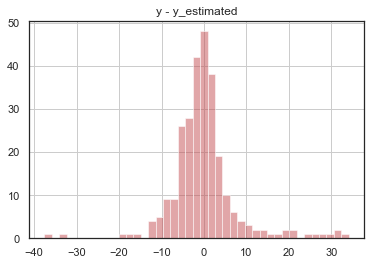

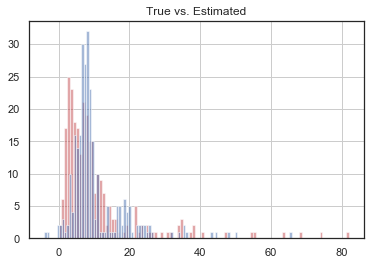

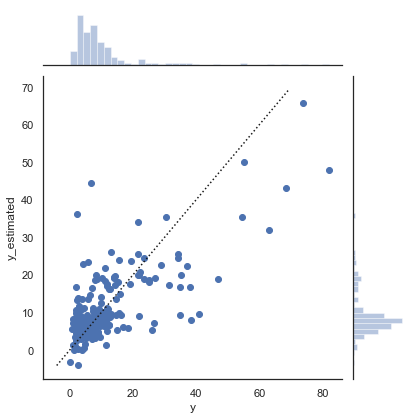

Mean Squared Error: 7.976185401686679
               feature       coef
0           max_counta   0.120941
1   avg_congested_prop  -0.714118
2           max_length   1.582246
3        max_avg_speed   2.644487
4        min_avg_speed  52.413954
5            avg_speed  12.121574
6     max_median_level  25.756590
7     min_median_level   0.739525
8         median_level  -1.201026
9         bool_highway   9.373265
10     usual_road_type  -1.866535


AttributeError: 'dict' object has no attribute 'reset_index'

In [323]:
from sklearn.linear_model import LinearRegression

df_features, X, y, index = prepare_features(waze_features, 'no_med')

models['Waze-SimpleLinearRegression'] = {'model': LinearRegression().fit(X, y)}

models = get_difference_from_y(X, y, models, 'Waze-SimpleLinearRegression', index, df_features.columns, bins=100)

## Gamma Regression with OSM data¶

In [ ]:
import numpy as np
import statsmodels.api as sm

df_features, X, y, index = prepare_features(waze_features, 'no_med')
_X = X
_X.insert(0, 'intercept', 1)

model = sm.GLM(y.values, _X, family=sm.families.Gamma())
models['Waze-SimpleGamma'] = {'model': model.fit(maxiter=1000)}

models['Waze-SimpleGamma']['model'].summary()

In [ ]:
models = get_difference_from_y(X, y, models, 'Waze-SimpleGamma', index, columns, bins=100)

## Looking for the features that are more important in the Linear Regression

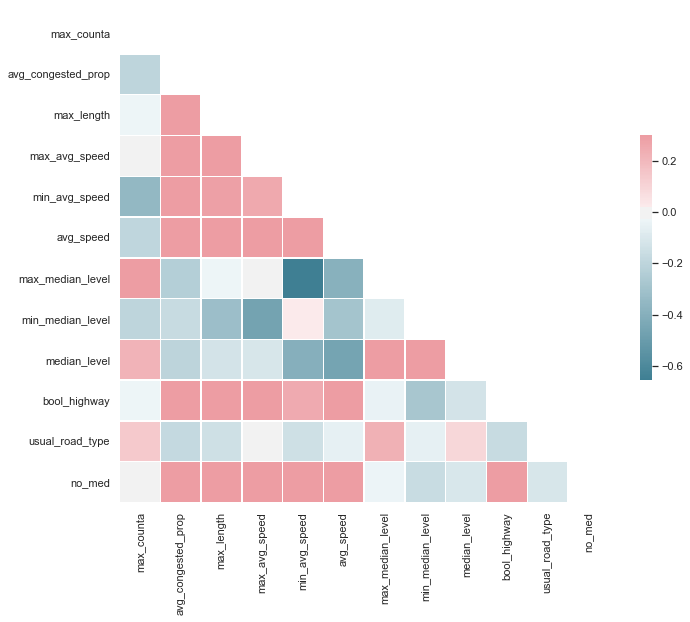

In [324]:
import seaborn as sns
sns.set(style="white")

# Compute the correlation matrix
corr = waze_features.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [325]:
waze_features.columns

Index(['h3id_9', 'max_counta', 'avg_congested_prop', 'max_length',
       'max_avg_speed', 'min_avg_speed', 'avg_speed', 'max_median_level',
       'min_median_level', 'median_level', 'bool_highway', 'usual_road_type',
       'no_med'],
      dtype='object')

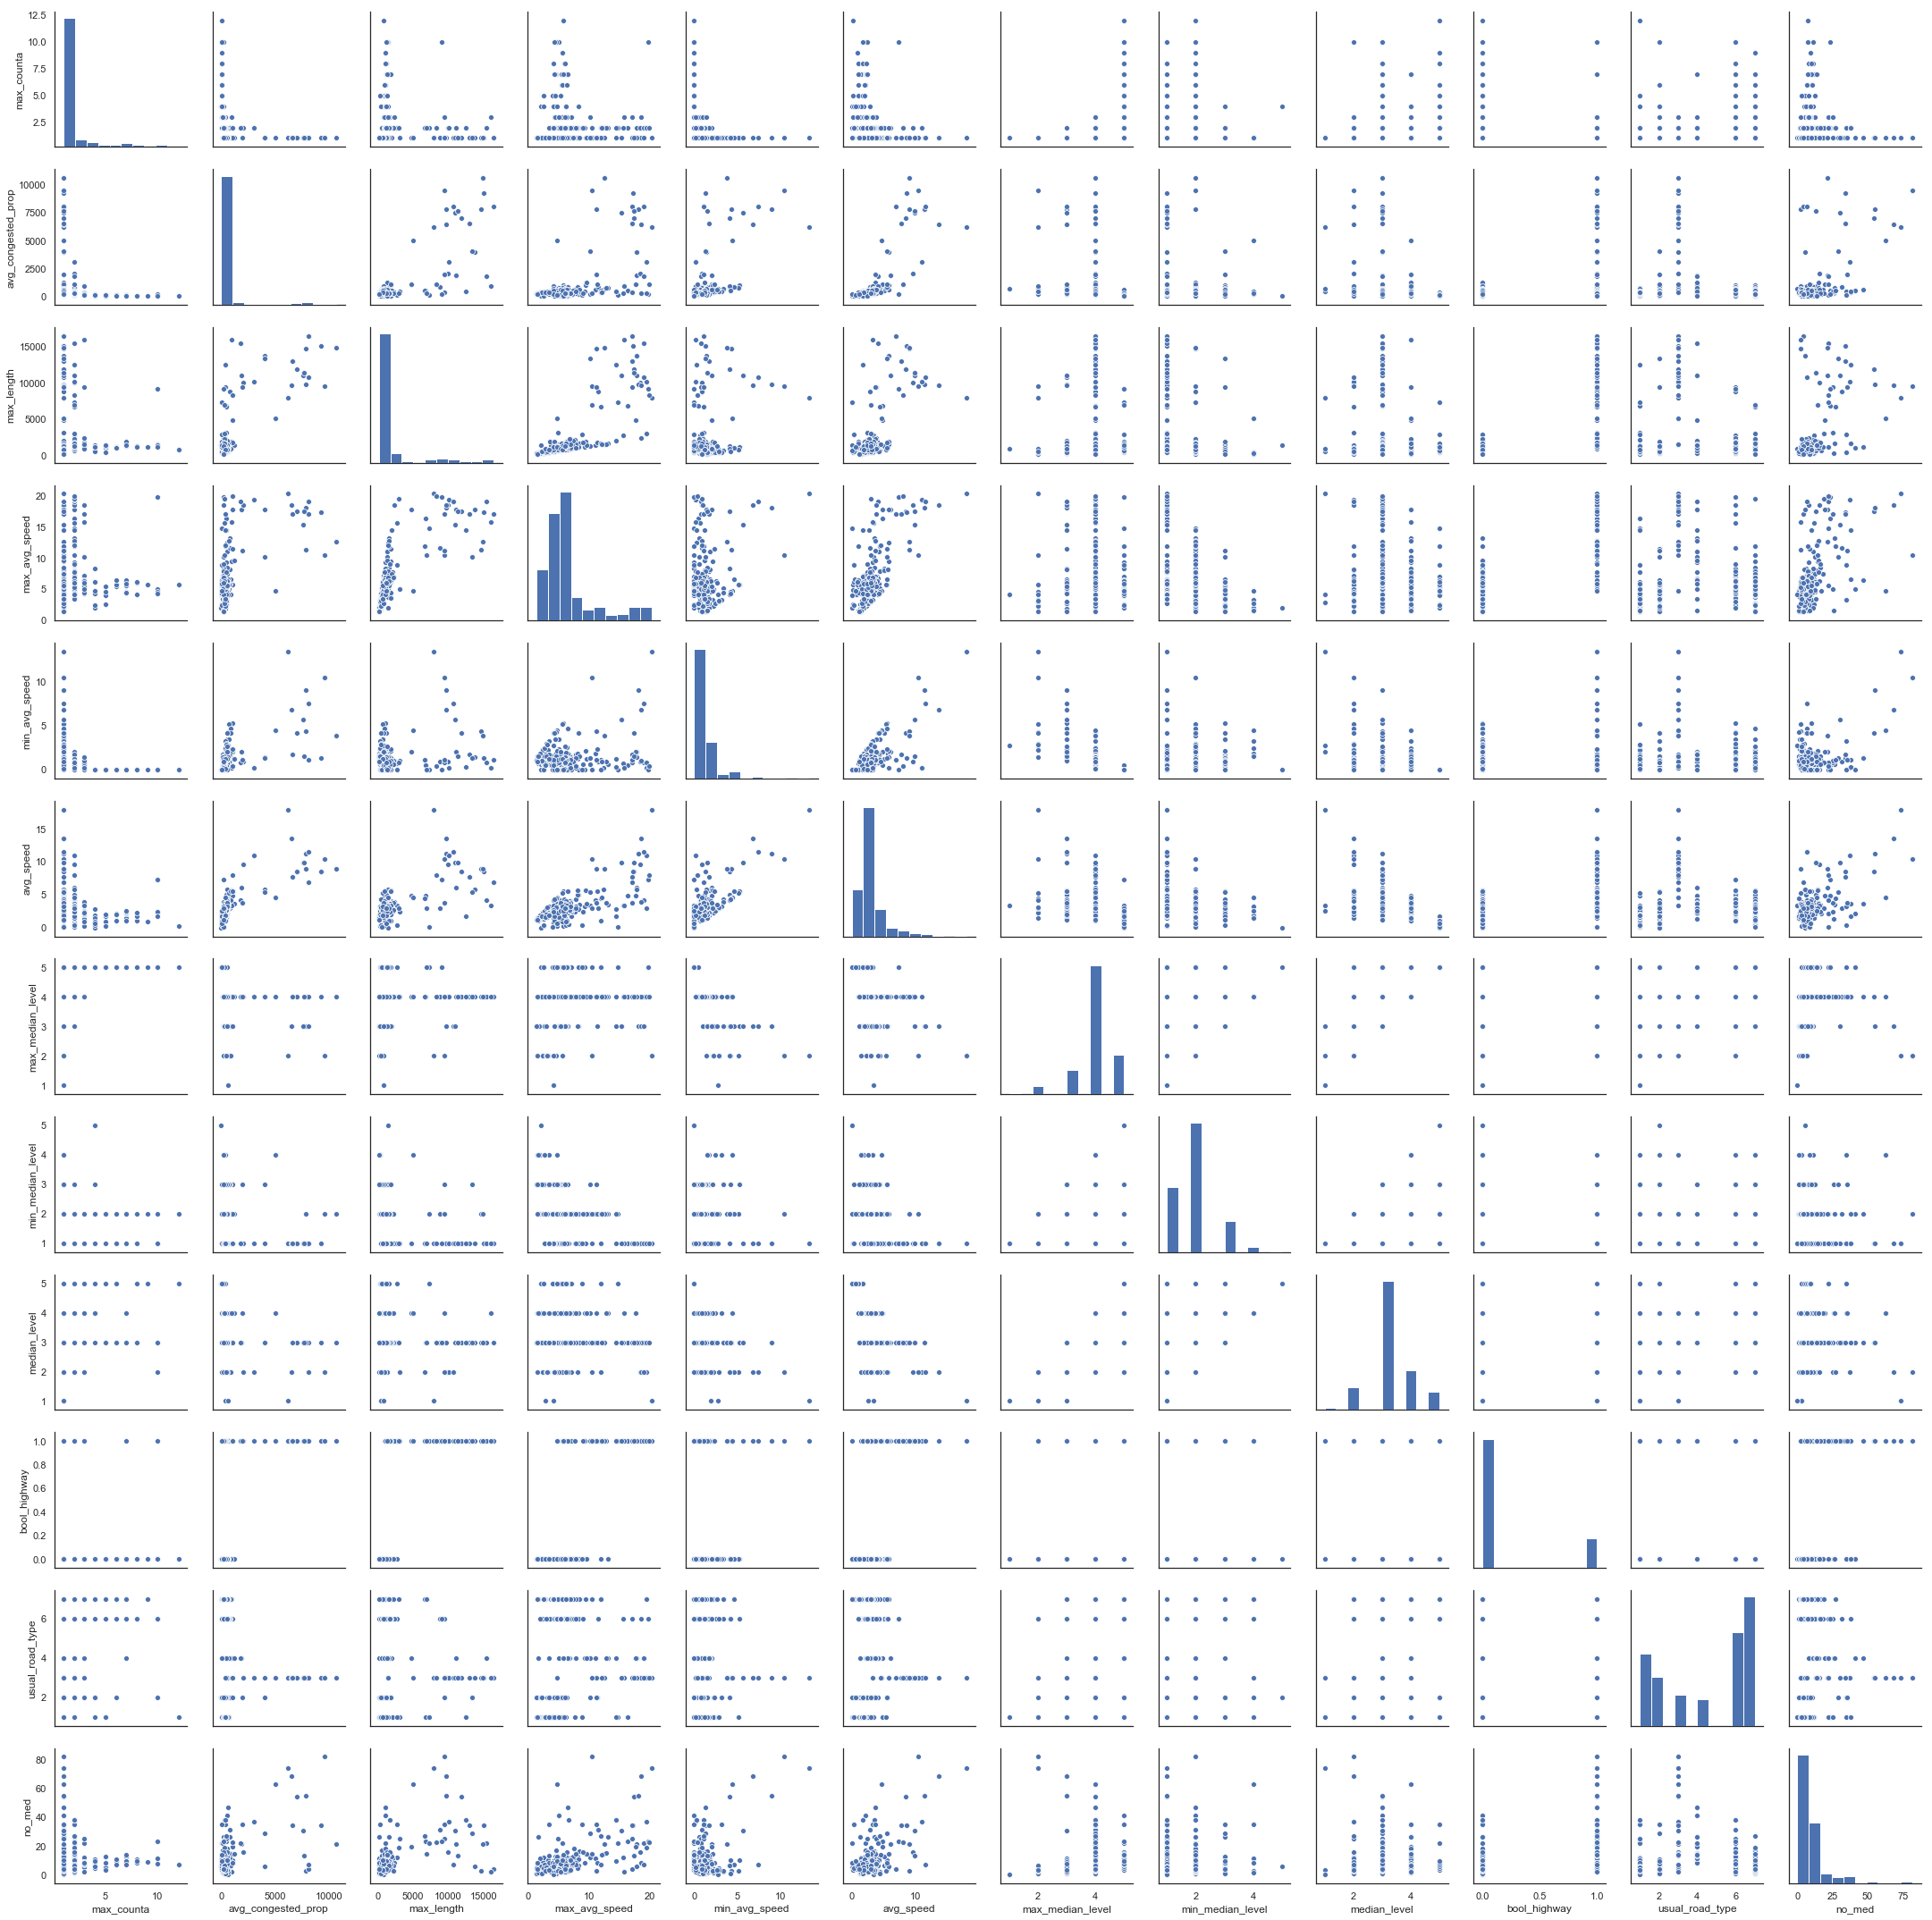

In [253]:
import seaborn as sns
sns.set(style="white")

sns_plot = sns.pairplot(waze_features[[ 'max_counta', 'avg_congested_prop', 'max_length',
       'max_avg_speed', 'min_avg_speed', 'avg_speed', 'max_median_level',
       'min_median_level', 'median_level', 'bool_highway', 'usual_road_type',
       'no_med']],)
sns_plot.savefig("../imgs/Waze-pairlot.png")

### Transforming some variables to handle Heteroscedasticity

In [326]:
waze_features['log_max_length'] = waze_features['max_length'].apply(np.log10)

In [327]:
waze_features['log_avg_congested_prop'] = waze_features['avg_congested_prop'].apply(np.log10)

In [328]:
waze_features['sqrt_no_med'] = waze_features['no_med'].apply(np.sqrt)

## Simple Linear Regression with transformed features

In [329]:
waze_features.columns

Index(['h3id_9', 'max_counta', 'avg_congested_prop', 'max_length',
       'max_avg_speed', 'min_avg_speed', 'avg_speed', 'max_median_level',
       'min_median_level', 'median_level', 'bool_highway', 'usual_road_type',
       'no_med', 'log_max_length', 'log_avg_congested_prop', 'sqrt_no_med'],
      dtype='object')

In [330]:
columns = ['h3id_9', 'max_counta', 
       'max_avg_speed', 'min_avg_speed', 'avg_speed', 'max_median_level',
       'min_median_level', 'median_level', 'bool_highway', 'usual_road_type',
       'no_med', 'log_max_length', 'log_avg_congested_prop', 'sqrt_no_med']

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


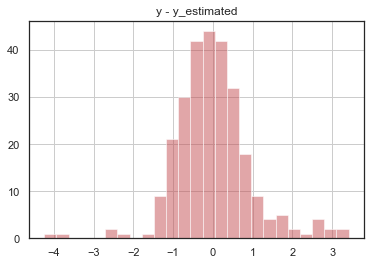

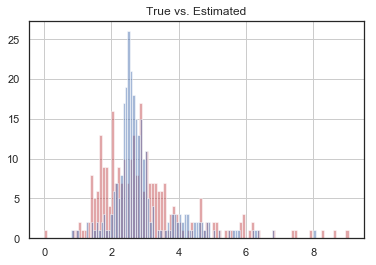

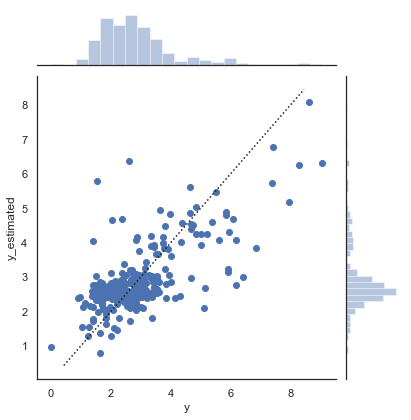

Mean Squared Error: 0.9708908995758604
                   feature      coef
0               max_counta -0.110145
1            max_avg_speed  0.445314
2            min_avg_speed  4.492651
3                avg_speed  1.311589
4         max_median_level  3.146050
5         min_median_level  0.217702
6             median_level -0.264326
7             bool_highway  1.024967
8          usual_road_type -0.175260
9           log_max_length  0.931651
10  log_avg_congested_prop -0.360269


AttributeError: 'dict' object has no attribute 'reset_index'

In [342]:
from sklearn.linear_model import LinearRegression

df_features, X, y, index = prepare_features(waze_features[columns], 'sqrt_no_med')

models['Waze-SimpleLinearRegression-transformed'] = {'model': LinearRegression().fit(X, y)}

models = get_difference_from_y(X, y, models, 'Waze-SimpleLinearRegression-transformed', index, df_features.columns, bins=100)

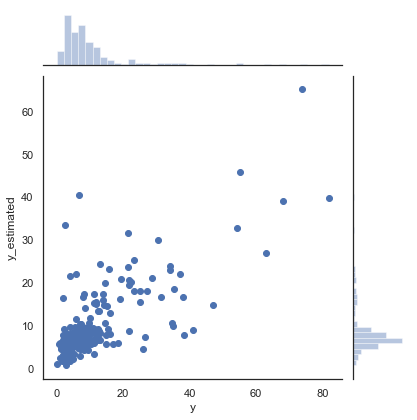

In [260]:
sns.jointplot(pd.Series(y.apply(lambda x: np.power(x, 2)).values, name='y'), 
                      pd.Series(models['Waze-SimpleLinearRegression-transformed']['y_estimated'].apply(lambda x: np.power(x, 2)), name='y_estimated'))



### It did not make a lot o difference

### Let's analyse the residuals

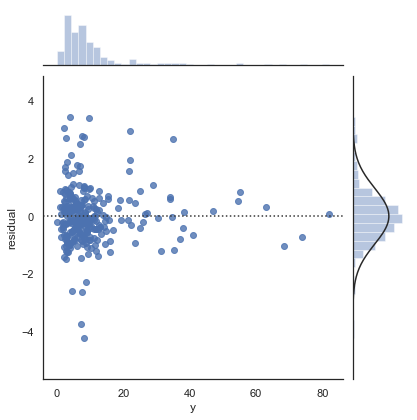

In [305]:
sns.jointplot(x=pd.Series(y.values, name='y'), 
              y=pd.Series(models['Waze-SimpleLinearRegression-transformed']['diff']['y - y_estimated'].values, name='residual'),
              kind='resid')

## OSM and WAZE

In [333]:
waze_features.head(1)

,h3id_9,max_counta,avg_congested_prop,max_length,max_avg_speed,min_avg_speed,avg_speed,max_median_level,min_median_level,median_level,bool_highway,usual_road_type,no_med,log_max_length,log_avg_congested_prop,sqrt_no_med
0,89283098147ffff,1,752.0,1076,4.966667,2.291667,3.36875,4,2,3,0,2,4.0,3.031812,2.876218,2.0


In [334]:
features.head(1)

,h3id_9,no_med,no2_med,bc_med,city,general_counta,node_counta,info_counta,highway_counta,natural_counta,place_counta,parking_counta,addr_street_counta,addr_housenumber_counta,amenity_counta,school_counta,restaurant_counta,place_of_worship_counta,shop_counta,name,parking,crossing
0,892830813b7ffff,8.296297,16.261263,0.554605,1,6,2,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [351]:
all_features = features.merge(waze_features, on=['h3id_9', 'no_med'])
all_features = all_features.drop(columns=['sqrt_no_med'])

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


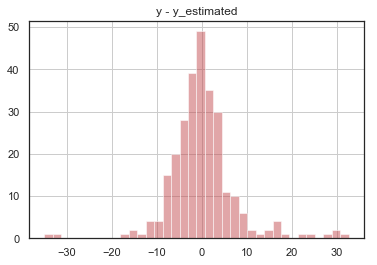

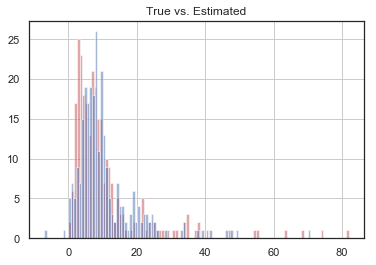

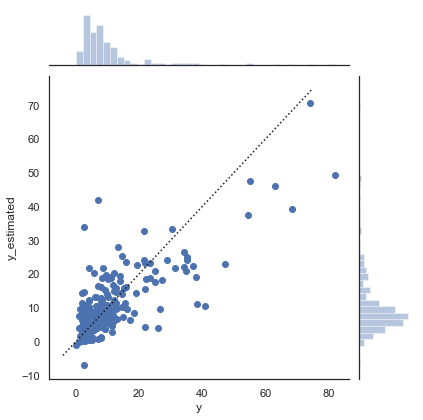

Mean Squared Error: 7.445956072672104
                    feature       coef
0            general_counta -24.616177
1               node_counta  97.733164
2               info_counta -14.399670
3            highway_counta -15.319335
4            natural_counta -10.310930
5              place_counta   2.618428
6            parking_counta  -5.174498
7        addr_street_counta   3.516740
8   addr_housenumber_counta  -0.035523
9            amenity_counta  -1.061006
10            school_counta  -4.208148
11        restaurant_counta  -6.736213
12  place_of_worship_counta  -0.844472
13              shop_counta   1.605785
14                     name -15.807097
15                  parking  -5.174498
16                 crossing  -8.814846
17               max_counta  -0.583228
18       avg_congested_prop   1.343492
19               max_length -12.734613
20            max_avg_speed  -4.312125
21            min_avg_speed  40.818059
22                avg_speed   8.343130
23         max_median_leve

AttributeError: 'dict' object has no attribute 'reset_index'

In [352]:
from sklearn.linear_model import LinearRegression

df_features, X, y, index = prepare_features(all_features, 'no_med')

models['WazeOSM-SimpleLinearRegression-transformed'] = {'model': LinearRegression().fit(X, y)}

models = get_difference_from_y(X, y, models, 'WazeOSM-SimpleLinearRegression-transformed', index, df_features.columns, bins=100)

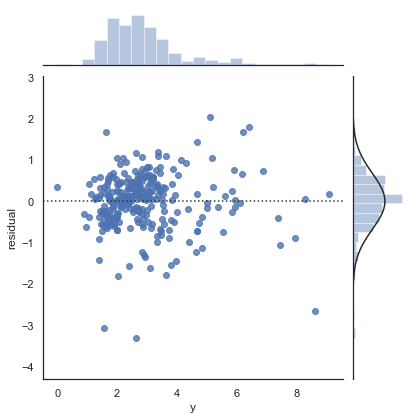

In [348]:
sns.jointplot(x=pd.Series(y.values, name='y'), y=pd.Series(models['WazeOSM-SimpleLinearRegression-transformed']['diff']['y - y_estimated'].values, name='residual'), kind='resid')

## Random Forest

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


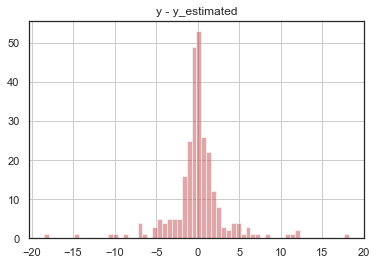

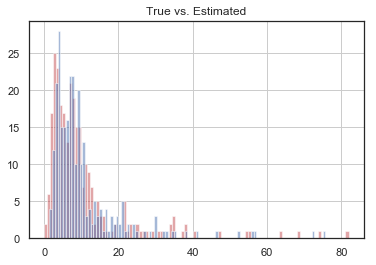

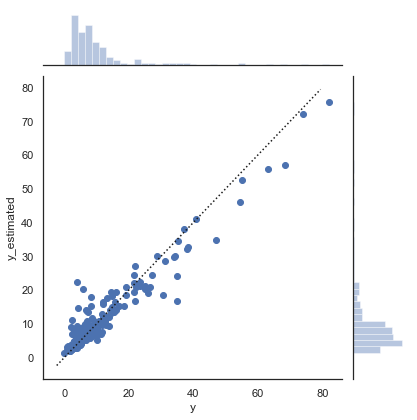

Mean Squared Error: 3.3483684182421194


AttributeError: 'RandomForestRegressor' object has no attribute 'coef_'

In [373]:
from sklearn.ensemble import RandomForestRegressor`

model_name = 'WazeOSM-SimpleRandomForest_minsplit2'

df_features, X, y, index = prepare_features(all_features, 'no_med')

models[model_name] = {'model': RandomForestRegressor(min_samples_split=2).fit(X, y)}

models = get_difference_from_y(X, y, models, model_name, index, df_features.columns, bins=100)

In [419]:
a = pd.DataFrame(models[model_name]['model'].feature_importances_, index=X.columns, columns=['Features']).sort_values(by='Features', ascending=False)

In [421]:
important_features = a[a['Features'] > 0.01].index

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


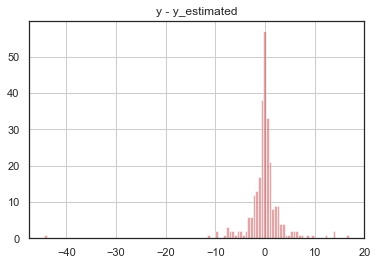

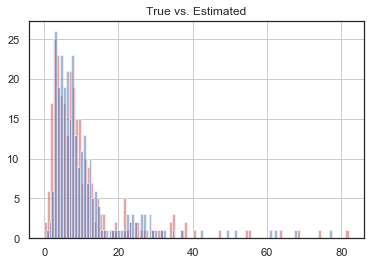

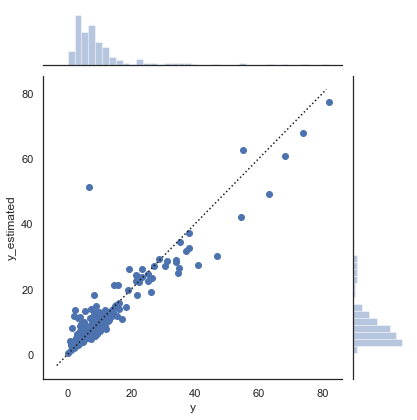

Mean Squared Error: 4.156427214444062


AttributeError: 'RandomForestRegressor' object has no attribute 'coef_'

In [394]:
from sklearn.ensemble import RandomForestRegressor

model_name = 'WazeOSM-SimpleRandomForest_minsplit4'

df_features, X, y, index = prepare_features(all_features, 'no_med')

models[model_name] = {'model': RandomForestRegressor(min_samples_split=2).fit(X, y)}

models = get_difference_from_y(X, y, models, model_name, index, df_features.columns, bins=100)

In [409]:
a = pd.DataFrame(models[model_name]['model'].feature_importances_, index=X.columns, columns=['Features']).sort_values(by='Features', ascending=False)

Index(['log_max_length', 'avg_speed', 'min_avg_speed', 'bool_highway',
       'highway_counta', 'info_counta', 'max_length', 'max_avg_speed',
       'general_counta', 'node_counta', 'amenity_counta', 'max_median_level',
       'min_median_level'],
      dtype='object')

In [402]:
from sklearn.model_selection import train_test_split

In [432]:
important_features = list(a[a['Features'] > 0.1].index) + ['h3id_9', 'no_med']

In [437]:
list(a[a['Features'] > 0.1].index)

['log_max_length', 'avg_speed', 'min_avg_speed']

In [438]:
all_features_important = all_features[important_features]

In [440]:
all_features_train, all_features_test = train_test_split(all_features_important, 
                                                    shuffle=True,
                                                    test_size=0.2, 
                                                    random_state=15)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


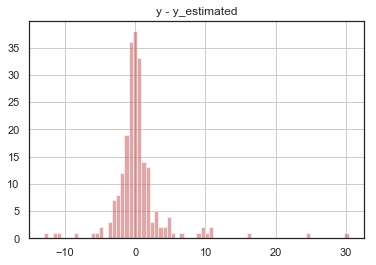

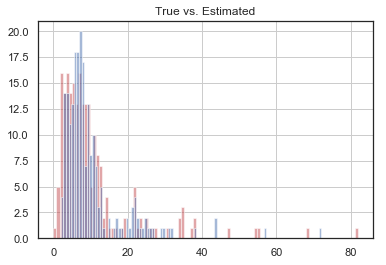

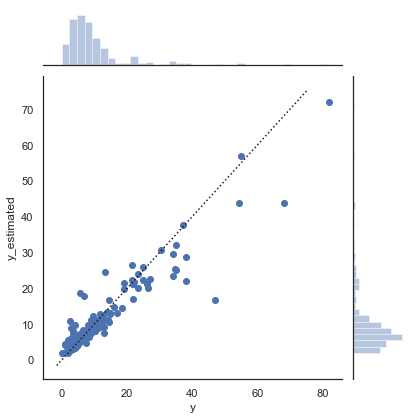

Mean Squared Error: 4.052674345630704


AttributeError: 'dict' object has no attribute 'reset_index'

In [441]:
from sklearn.ensemble import RandomForestRegressor

model_name = 'WazeOSM-SimpleRandomForest_minsplit2'

df_features, X, y, index = prepare_features(all_features_train, 'no_med')

models[model_name] = {'model': RandomForestRegressor(min_samples_split=2).fit(X, y)}

models = get_difference_from_y(X, y, models, model_name, index, df_features.columns, bins=100)

--------------
TEST DATA
--------------


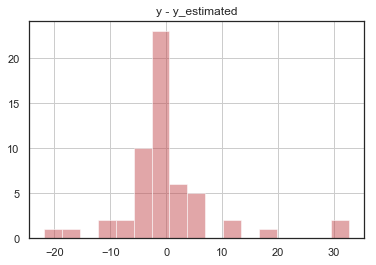

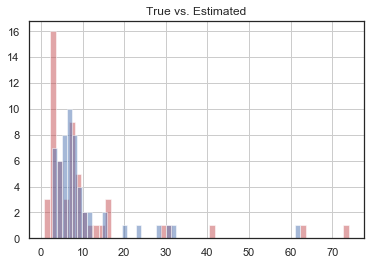

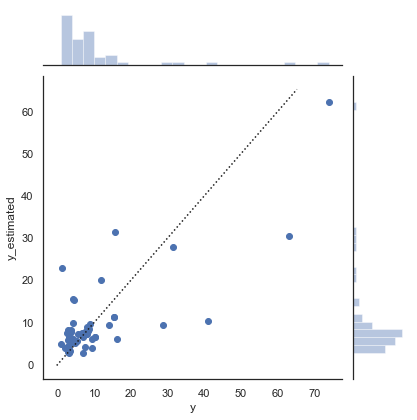

Mean Squared Error: 8.555075883169689


AttributeError: 'dict' object has no attribute 'reset_index'

In [442]:
print('-' * 14)
print('TEST DATA')
print('-' * 14)
df_features, X, y, index = prepare_features(all_features_test, 'no_med')

models = get_difference_from_y(X, y, models, model_name, index, df_features.columns, bins=50)

In [452]:
models[model_name]['diff'].sort_values('y - y_estimated', ascending=False).reset_index().merge(all_features, on='h3id_9')

,h3id_9,y - y_estimated,no_med,no2_med,bc_med,city,general_counta,node_counta,info_counta,highway_counta,natural_counta,place_counta,parking_counta,addr_street_counta,addr_housenumber_counta,amenity_counta,school_counta,restaurant_counta,place_of_worship_counta,shop_counta,name,parking,crossing,max_counta,avg_congested_prop,max_length,max_avg_speed,min_avg_speed,avg_speed,max_median_level,min_median_level,median_level,bool_highway,usual_road_type,log_max_length,log_avg_congested_prop
0,8928308152bffff,32.583988,63.073022,37.600032,2.020572,1,50,21,13,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,5039.000000,5039,4.691667,4.425000,4.613333,4,4,4,1,3,3.702344,3.702344
1,89283081187ffff,30.569697,40.931817,31.402429,1.642146,1,4,2,4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,525.607143,1073,4.983333,0.000000,2.144593,5,2,3,0,4,3.030600,2.720661
2,89283099897ffff,19.537970,28.808334,23.559138,0.704318,2,208,29,38,29,0,0,0,0,0,0,0,0,0,0,3,0,28,1,4025.040000,13416,10.138889,1.344444,5.440111,4,3,3,1,2,4.127623,3.604770
3,8928308152fffff,11.652601,73.919997,40.508133,2.570939,1,66,33,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,6198.000000,7885,20.283333,13.330556,17.887500,2,1,1,1,3,3.896802,3.792252
4,89283098ed7ffff,10.231500,16.095238,16.465953,0.744195,2,78,9,35,3,0,0,0,0,0,0,0,0,0,1,4,0,0,1,589.302632,1620,8.466667,1.513889,3.540278,4,1,3,0,7,3.209515,2.770338
5,8928309816fffff,5.263016,9.198215,11.774021,0.559901,2,6,3,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,357.000000,728,5.077778,1.072222,2.332885,4,2,3,0,2,2.862131,2.552668
6,89283081313ffff,4.760440,13.964286,17.390973,0.598108,1,140,26,51,19,0,0,0,0,0,2,0,0,2,0,4,0,20,2,369.987113,1480,12.077778,0.941667,4.520342,4,2,3,1,3,3.170262,2.568187
7,89283098167ffff,4.334559,15.453749,17.101380,0.633839,2,104,23,48,10,0,0,0,0,0,5,0,1,0,0,8,0,12,1,579.489362,1370,6.319444,0.000000,3.314953,5,1,3,0,6,3.136721,2.763045
8,8928308118fffff,4.297356,6.987805,15.578679,0.545846,1,40,4,37,1,0,1,0,0,0,0,0,0,0,0,3,0,0,1,326.285714,406,2.633333,1.525000,1.856746,3,1,3,0,1,2.608526,2.513598
9,892830813a3ffff,3.923608,15.229885,20.865157,0.665650,1,90,9,53,5,0,0,0,1,1,1,0,0,0,3,6,0,0,2,742.337180,1548,12.772222,0.916667,3.714962,4,2,4,1,4,3.189771,2.870601


In [447]:
# Extract single tree
estimator = models[model_name]['model'].estimators_[5]

from sklearn.tree import export_graphviz
# Export as dot file
export_graphviz(estimator, out_file='tree.dot', 
                feature_names = important_features[:-2],
                class_names = ['no_med'],
                rounded = True, proportion = False, 
                precision = 2, filled = True)

# Convert to png using system command (requires Graphviz)
from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

# Display in jupyter notebook
from IPython.display import Image
Image(filename = 'tree.png')

## Is it distributed as a power law

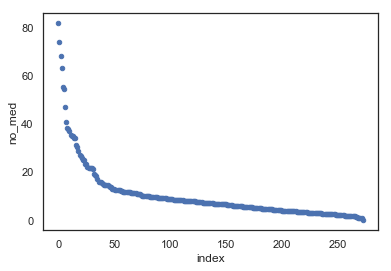

In [467]:
a = all_features['no_med'].sort_values(ascending=False).reset_index(drop=True).reset_index()
a.plot(kind='scatter', x='index', y='no_med')

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/pandas/core/frame.py:5066: RuntimeWarning: divide by zero encountered in log10
  return lib.map_infer(x.asobject, func)


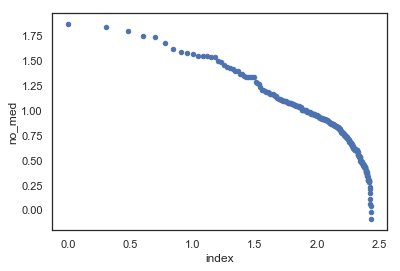

In [498]:
ax = a.applymap(np.log10).plot(kind='scatter', x='index', y='no_med')

### Per city

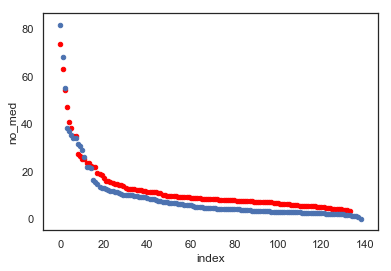

In [524]:
a = all_features[all_features['city'] == 1]['no_med'].sort_values(ascending=False).reset_index(drop=True).reset_index()

b = all_features[all_features['city'] == 2]['no_med'].sort_values(ascending=False).reset_index(drop=True).reset_index()
ax = a.plot(kind='scatter', x='index', y='no_med', color='red')
b.plot(kind='scatter', x='index', y='no_med', ax=ax)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/pandas/core/frame.py:5066: RuntimeWarning: divide by zero encountered in log10
  return lib.map_infer(x.asobject, func)


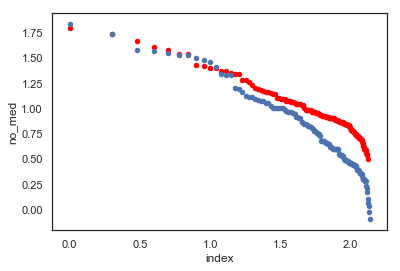

In [526]:
ax = a.applymap(np.log10).plot(kind='scatter', x='index', y='no_med', color='red')
b.applymap(np.log10).plot(kind='scatter', x='index', y='no_med', ax=ax)

## Ploting model results to get a visual cue of which feature can be built

In [344]:
plot_df = waze_features[['h3id_9', 'no_med']]

for name, values in models.items():
    
    for value in values.keys():

        if value != 'model':
            print(name)
            print(value)
            
            if value == 'diff':
                
                plot_df = pd.merge(plot_df,
                    models[name][value].rename(columns={'y - y_estimated':f'{name}-{value}'}).reset_index(),
                     on='h3id_9')
            else:
                

                plot_df = pd.merge(plot_df,
                    models[name][value].to_frame().rename(columns={0:f'{name}-{value}'}).reset_index(),
                     on='h3id_9')

OSM-SimpleLinearRegression
y_estimated
OSM-SimpleLinearRegression
diff
Waze-SimpleLinearRegression
y_estimated
Waze-SimpleLinearRegression
diff
Waze-SimpleGamma
y_estimated
Waze-SimpleGamma
diff
Waze-SimpleLinearRegression-transformed
y_estimated
Waze-SimpleLinearRegression-transformed
diff


In [345]:
len(waze_features) == len(plot_df)

True

In [346]:
plot_df.to_csv(OUTPUT_PATH / 'pollution_models' / 'kepler_simple_models_output.csv')

## Merging with previous features

In [ ]:
all_features = waze_features.merge(features, on='h3id_9')

In [ ]:
all_features = all_features.rename(columns={'no_med_x': 'no_med'})

In [4]:
del all_features['no_med_y']

NameError: name 'all_features' is not defined

## Simple Linear Regression with All Features

In [5]:
sns.reset_orig()

NameError: name 'sns' is not defined

In [6]:
from sklearn.linear_model import LinearRegression

df_features, X, y, index = prepare_features(all_features, 'no_med')

models['All-SimpleLinearRegression'] = LinearRegression().fit(X, y)

diff = get_difference_from_y(X, y, models, 'All-SimpleLinearRegression', index, bins=100)

NameError: name 'prepare_features' is not defined

In [ ]:
import numpy as np
import statsmodels.api as sm

df_features, X, y, index = prepare_features(all_features, 'no_med')
_X = X
_X.insert(0, 'intercept', 1)

model = sm.GLM(y.values, _X, family=sm.families.Gamma())
models['All-SimpleGamma'] = model.fit(maxiter=1000)

models['All-SimpleGamma'].summary()

In [ ]:
diff = get_difference_from_y(X, y, models, 'All-SimpleGamma', index, bins=100)

# Model Tuning

[Model Tuning (Part 2 - Validation & Cross-Validation)]('https://dziganto.github.io/cross-validation/data%20science/machine%20learning/model%20tuning/python/Model-Tuning-with-Validation-and-Cross-Validation/')

In [ ]:
def calc_train_error(X_train, y_train, model):
    '''returns in-sample error for already fit model.'''
    predictions = model.predict(X_train)
    mse = mean_squared_error(y_train, predictions)
    rmse = np.sqrt(mse)
    return mse
    
def calc_validation_error(X_test, y_test, model):
    '''returns out-of-sample error for already fit model.'''
    predictions = model.predict(X_test)
    mse = mean_squared_error(y_test, predictions)
    rmse = np.sqrt(mse)
    return mse
    
def calc_metrics(X_train, y_train, X_test, y_test, model):
    '''fits model and returns the RMSE for in-sample error and out-of-sample error'''
    model.fit(X_train, y_train)
    train_error = calc_train_error(X_train, y_train, model)
    validation_error = calc_validation_error(X_test, y_test, model)
    return train_error, validation_error

In [ ]:
features, data, target, index = prepare_features(features, 'no_med')

## Training and Test

In [ ]:
X_train, X_test, y_train, y_test = train_test_split( data, target,
                                                    shuffle=True,
                                                    test_size=0.2, 
                                                    random_state=15)

In [ ]:
lr = LinearRegression(fit_intercept=True)

train_error, test_error = calc_metrics(X_train, y_train, X_test, y_test, lr)
train_error, test_error = round(train_error, 3), round(test_error, 3)

print('train error: {} | test error: {}'.format(train_error, test_error))
print('train/test: {}'.format(round(test_error/train_error, 1)))

## Training, Test and Validation

In [ ]:
# intermediate/test split (gives us test set)
X_intermediate, X_test, y_intermediate, y_test = train_test_split(X, 
                                                                  y, 
                                                                  shuffle=True,
                                                                  test_size=0.2, 
                                                                  random_state=15)

# train/validation split (gives us train and validation sets)
X_train, X_validation, y_train, y_validation = train_test_split(X_intermediate,
                                                                y_intermediate,
                                                                shuffle=False,
                                                                test_size=0.25,
                                                                random_state=2018)

In [ ]:
# delete intermediate variables
#del X_intermediate, y_intermediate

# print proportions
print('train: {}% | validation: {}% | test {}%'.format(round(len(y_train)/len(X),2),
                                                       round(len(y_validation)/len(X),2),
                                                       round(len(y_test)/len(X),2)))z

### Regularization

In [ ]:
from sklearn.linear_model.ridge import Ridge

In [ ]:
alphas = [0.001, 0.01, 0.1, 1, 10]
print('All errors are RMSE')
print('-'*76)
for alpha in alphas:
    # instantiate and fit model
    ridge = Ridge(alpha=alpha, fit_intercept=True, random_state=99)
    ridge.fit(X_train, y_train)
    # calculate errors
    new_train_error = mean_squared_error(y_train, ridge.predict(X_train))
    new_validation_error = mean_squared_error(y_validation, ridge.predict(X_validation))
    new_test_error = mean_squared_error(y_test, ridge.predict(X_test))
    # print errors as report
    print('alpha: {:7} | train error: {:5} | val error: {:6} | test error: {}'.
          format(alpha,
                 round(new_train_error,3),
                 round(new_validation_error,3),
                 round(new_test_error,3)))

In [ ]:
# train/test split
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    shuffle=True,
                                                    test_size=0.2, 
                                                    random_state=15)

# instantiate model
ridge = Ridge(alpha=1, fit_intercept=True, random_state=99)

# fit and calculate errors
new_train_error, new_test_error = calc_metrics(X_train, y_train, X_test, y_test, ridge)
new_train_error, new_test_error = round(new_train_error, 3), round(new_test_error, 3)

In [7]:
print('ORIGINAL ERROR')
print('-' * 40)
print('train error: {} | test error: {}\n'.format(train_error, test_error))
print('ERROR w/REGULARIZATION')
print('-' * 40)
print('train error: {} | test error: {}'.format(new_train_error, new_test_error))

ORIGINAL ERROR
----------------------------------------


NameError: name 'train_error' is not defined

### Cross Validation

In [8]:
from sklearn.linear_model import Lasso

In [9]:
from sklearn.model_selection import cross_val_score

alphas = [1e-4, 1e-3, 1e-2, 1e-1, 1, 1e1]

val_errors = []
for alpha in alphas:
    lasso = Lasso(alpha=alpha, fit_intercept=True, random_state=77)
    errors = np.sum(-cross_val_score(lasso, 
                                     X, 
                                     y=y, 
                                     scoring='neg_mean_squared_error', 
                                     cv=10, 
                                     n_jobs=-1))
    val_errors.append(np.sqrt(errors))

NameError: name 'X' is not defined

In [251]:
# RMSE
print(val_errors)

[37.90803654505672, 37.63943929518079, 36.784307835165116, 36.08539270165429, 36.06261998855761, 36.06261998855761]


In [250]:
print('best alpha: {}'.format(alphas[np.argmin(val_errors)]))

best alpha: 1


## KFold

In [262]:
from sklearn.model_selection import KFold

K = 10
kf = KFold(n_splits=K, shuffle=True, random_state=42)

for alpha in alphas:
    train_errors = []
    validation_errors = []
    for train_index, val_index in kf.split(X, y):

        # split data
        X_train, X_val = X.values[train_index], X.values[val_index]
        y_train, y_val = y[train_index], y[val_index]

        # instantiate model
        lasso = Lasso(alpha=alpha, fit_intercept=True, random_state=77)
        
        #calculate errors
        train_error, val_error = calc_metrics(X_train, y_train, X_val, y_val, lasso)
        
        # append to appropriate list
        train_errors.append(train_error)
        validation_errors.append(val_error)
    
    # generate report
    print('alpha: {:6} | mean(train_error): {:7} | mean(val_error): {}'.
          format(alpha,
                 round(np.mean(train_errors),4),
                 round(np.mean(validation_errors),4)))

alpha: 0.0001 | mean(train_error): 116.5316 | mean(val_error): 132.68
alpha:  0.001 | mean(train_error): 116.5553 | mean(val_error): 131.5862
alpha:   0.01 | mean(train_error): 117.7565 | mean(val_error): 127.8478
alpha:    0.1 | mean(train_error): 128.7941 | mean(val_error): 130.3739
alpha:      1 | mean(train_error): 129.5988 | mean(val_error): 130.137
alpha:   10.0 | mean(train_error): 129.5988 | mean(val_error): 130.137


### Full Dataset Train

train error: 10.824583412695949


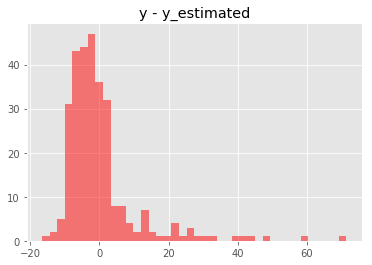

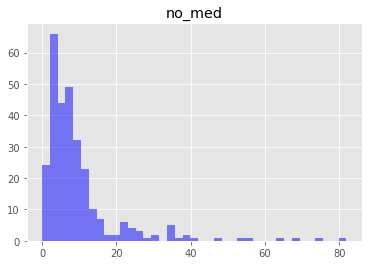

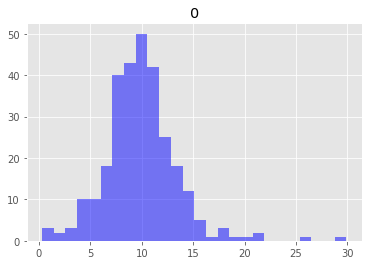

In [316]:
diff = get_difference_from_y(X, y, models, 'SimpleLinearRegression', index)

In [51]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


In [332]:
data = sm.datasets.scotland.load()

In [336]:
np.shape(data.exog), np.shape(data.endog)

((32, 7), (32,))

In [300]:
models['lasso_alpha_0.1'] = Lasso(alpha=0.1, fit_intercept=True, random_state=77).fit(X, y)

train error: 11.353656857989716


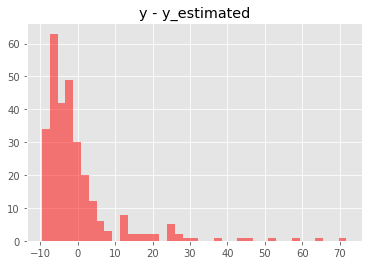

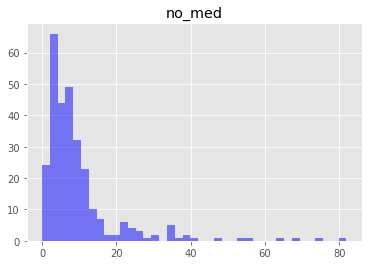

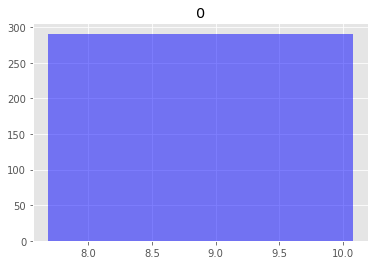

In [301]:
diff = get_difference_from_y(X, y, models,'lasso_alpha_0.1', index)

In [319]:
models['ridge_alpha_0.1'] = Ridge(alpha=100, fit_intercept=True, random_state=99)

train error: 11.353656857989716


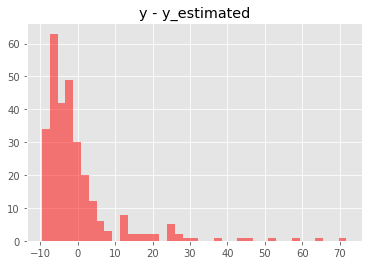

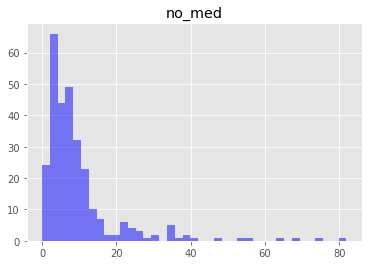

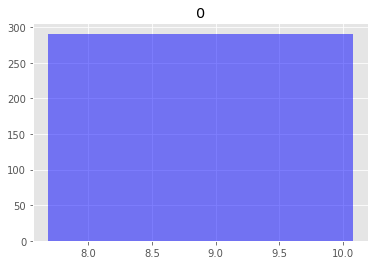

In [320]:
diff = get_difference_from_y(X, y, models,'lasso_alpha_0.1', index)

https://github.com/datascienceinc/Skater/blob/master/examples/ensemble_model.ipynb

In [161]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import pandas as pd
# Reference for customizing matplotlib: https://matplotlib.org/users/style_sheets.html
plt.style.use('ggplot')

from sklearn.model_selection import train_test_split

from sklearn import svm
from sklearn import model_selection
from sklearn import tree

from skater.core.explanations import Interpretation
from skater.model import InMemoryModel

In [162]:
def scores(model):
    
    seed = 7
    kfold = model_selection.KFold(n_splits=10, random_state=seed)
    scoring = 'neg_mean_absolute_error'
    results = model_selection.cross_val_score(model, X, y, cv=kfold, scoring=scoring)
    print("MAE: {} ({})".format(results.mean(), results.std()))
    scoring = 'neg_mean_squared_error'
    results = model_selection.cross_val_score(model, X, y, cv=kfold, scoring=scoring)
    print("MSE: {} ({})".format(results.mean(), results.std()))
    scoring = 'r2'
    results = model_selection.cross_val_score(model, X, y, cv=kfold, scoring=scoring)
    print("R^2: {} ({})".format(results.mean(), results.std()))

In [163]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2)


models = {'LinearRegression':LinearRegression(), 
          'SVM': svm.SVR(),
          'DecisionTree10': tree.DecisionTreeRegressor(max_depth=10),
          'DecisionTree5': tree.DecisionTreeRegressor(max_depth=5)
         }

for name, clf in models.items():
    print()
    print(name)
    scores(clf)
    models[name] = clf.fit(X_train, y_train.values)
    



LinearRegression
MAE: -8.117033652625958 (2.4585491638604027)
MSE: -240.04795846550914 (279.98578077331024)
R^2: -1.723949032044371 (4.308308847124525)

SVM
MAE: -5.654614020372906 (1.8522161772989902)
MSE: -150.25554170855892 (130.46512265438784)
R^2: -0.1798240478658349 (0.11434583211918241)

DecisionTree10
MAE: -8.898193505731054 (2.6169659050077256)
MSE: -296.08147498518576 (162.03448436837883)
R^2: -1.6770296276681402 (2.073764937063088)

DecisionTree5
MAE: -7.892428951535611 (2.0372567363472323)
MSE: -202.05627959068156 (126.19085015709035)
R^2: -1.1632317058213495 (1.8906746825135345)


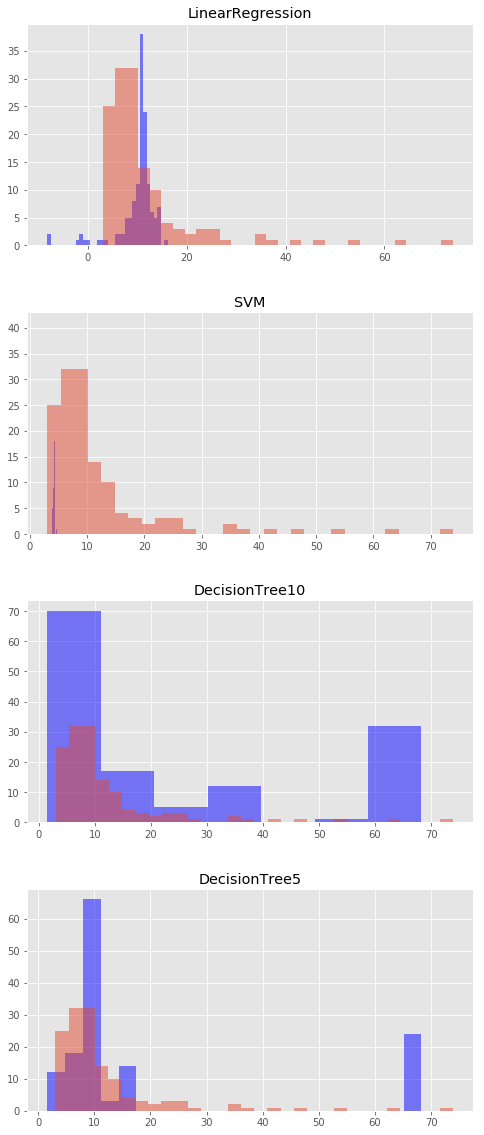

In [165]:
f, axes = plt.subplots(len(models), 1, figsize = (8, len(models)*5))

ax_dict = {name: axes[i] for i, name in enumerate(models.keys())}

for model_key in models:
    ax = ax_dict[model_key]
    pd.DataFrame(models[model_key].predict(X_valid)).hist(alpha=0.5, color='blue', bins='fd', ax=ax)
    y_valid.hist(alpha=0.5, bins='fd', ax=ax)
    ax.set_title(model_key)

In [108]:
len(y), len(a.predict(X))

(291, 291)